TASK 2: Emotion Recognition from Speech

Step 1: Import Libraries

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


Step 2: Load Dataset (TESS)

In [2]:
# Path to your TESS dataset folder
DATASET_PATH = "C:\\Users\\1 Click\\Desktop\\CodeAlpha\\archive\\TESS Toronto emotional speech set data"
# "/content/TESS_Toronto_emotional_speech_set"

# Function to extract label from file name
def get_emotion_from_filename(filename):
    # Example: 'OAF_angry.wav' -> 'angry'
    return filename.split('_')[-1].replace('.wav', '')

# Collect file paths and labels
file_paths = []
labels = []

for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith(".wav"):
            file_paths.append(os.path.join(root, file))
            labels.append(get_emotion_from_filename(file))

# Create dataframe
data = pd.DataFrame({"path": file_paths, "emotion": labels})
print(data.head(500))


                                                  path emotion
0    C:\Users\1 Click\Desktop\CodeAlpha\archive\TES...   angry
1    C:\Users\1 Click\Desktop\CodeAlpha\archive\TES...   angry
2    C:\Users\1 Click\Desktop\CodeAlpha\archive\TES...   angry
3    C:\Users\1 Click\Desktop\CodeAlpha\archive\TES...   angry
4    C:\Users\1 Click\Desktop\CodeAlpha\archive\TES...   angry
..                                                 ...     ...
495  C:\Users\1 Click\Desktop\CodeAlpha\archive\TES...    fear
496  C:\Users\1 Click\Desktop\CodeAlpha\archive\TES...    fear
497  C:\Users\1 Click\Desktop\CodeAlpha\archive\TES...    fear
498  C:\Users\1 Click\Desktop\CodeAlpha\archive\TES...    fear
499  C:\Users\1 Click\Desktop\CodeAlpha\archive\TES...    fear

[500 rows x 2 columns]


In [3]:
data["emotion"].value_counts()

emotion
angry      800
disgust    800
fear       800
happy      800
neutral    800
ps         800
sad        800
Name: count, dtype: int64

Step 3:Explore Data Analysis

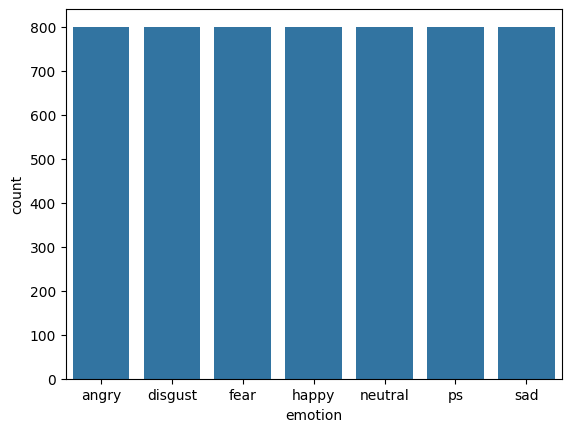

In [4]:
sns.countplot(x='emotion', data=data)
plt.show()

Step 4: Feature Extraction (MFCCs)

In [5]:
%pip install resampy

def extract_features(file_path, max_pad_len=174):
    # Load audio
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast') 
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    
    # Pad or truncate to fixed length
    if mfccs.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
    
    return mfccs

# Apply feature extraction
X = []
for path in data['path']:
    features = extract_features(path)
    X.append(features)

X = np.array(X)
print("Feature shape:", X.shape)




Note: you may need to restart the kernel to use updated packages.
Feature shape: (5600, 40, 174)


Step 5: Encode Labels

In [6]:
# Encode string labels (happy, sad, angry, etc.) to numbers
lb = LabelEncoder()
y = lb.fit_transform(data['emotion'])
y = to_categorical(y)

print("Classes:", lb.classes_)
print("y shape:", y.shape)


Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'ps' 'sad']
y shape: (5600, 7)


Step 6: Train-Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM expects 3D input (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (4480, 174, 40)
Test shape: (1120, 174, 40)


Step 7: Build LSTM Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(128, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()




c:\Users\1 Click\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,239 (372.03 KB)

 Trainable params: 95,239 (372.03 KB)

 Non-trainable params: 0 (0.00 B)

Step 8: Train Model

In [9]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=8, batch_size=32)


Epoch 1/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.4375 - loss: 1.4601 - val_accuracy: 0.7571 - val_loss: 0.7021
Epoch 2/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.8199 - loss: 0.5269 - val_accuracy: 0.8866 - val_loss: 0.3286
Epoch 3/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9205 - loss: 0.2403 - val_accuracy: 0.9473 - val_loss: 0.1511
Epoch 4/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 217ms/step - accuracy: 0.9525 - loss: 0.1502 - val_accuracy: 0.9634 - val_loss: 0.1375
Epoch 5/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 0.9730 - loss: 0.0972 - val_accuracy: 0.9732 - val_loss: 0.1034
Epoch 6/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9844 - loss: 0.0559 - val_accuracy: 0.9643 - val_loss: 0.1091
Epoch 7/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9826 - loss: 0.0565 - val_accuracy: 0.9714 - val_loss: 0.0974
Epoch 8/8
140/140 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.9797 - loss: 0.0663 - 

Step 9: Evaluate Model

In [10]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {acc*100:.2f}%")


✅ Test Accuracy: 95.71%


Step 10: Predict Emotion for New Audio

In [11]:
def predict_emotion(file_path):
    feature = extract_features(file_path)
    feature = feature.reshape(1, feature.shape[1], feature.shape[0])
    prediction = model.predict(feature)
    emotion = lb.inverse_transform([np.argmax(prediction)])
    return emotion[0]

# Example: predict first file
print("Prediction:", predict_emotion(file_paths[0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Prediction: angry


In [12]:
print(file_paths[0])
print("Prediction:", predict_emotion(file_paths[499]))

C:\Users\1 Click\Desktop\CodeAlpha\archive\TESS Toronto emotional speech set data\OAF_angry\OAF_back_angry.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction: fear


In [14]:
import joblib

model.save("emotion_model.h5")
joblib.dump(lb, "label_encoder.pkl")


['label_encoder.pkl']